In [1]:
# https://www.kaggle.com/dlarionov/feature-engineering-xgboost
import numpy as np
import pandas as pd

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBRegressor
from xgboost import plot_importance

from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, space_eval

import time
import sys
import gc
import pickle

In [2]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [3]:
data = pd.read_pickle('../data/data.pkl')
test = pd.read_pickle('../data/test.pkl')

In [4]:
# Select features. Got here through trial and error
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale'
]]

In [5]:
# Validation strategy is 34 month for the test set,
#33 month for the validation set and 13-33 months for the train.
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']

X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
del data
gc.collect();

In [7]:
# Use XGBoost and hyperopt
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#parameters-for-tree-booster
def score(params):
    model = XGBRegressor(**params)
    
    model.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
              verbose=False, early_stopping_rounds=10)
    Y_pred = model.predict(X_valid).clip(0, 20)
    score = sqrt(mean_squared_error(Y_valid, Y_pred))
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials):
    space = {
        'max_depth':hp.choice('max_depth', np.arange(10, 25, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(1000, 10000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(250, 350, 10, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'eta':hp.quniform('eta', 0.1, 0.3, 0.1),
        
        'objective':'reg:squarederror',
        
        'tree_method':'gpu_hist',
        'eval_metric': 'rmse'
    }
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=10)
    return best

In [8]:
trials = Trials()
best_params = optimize(trials)

0.9020715278105548                                  
0.8953501854865944                                                           
0.8928403239709671                                                           
0.9073460626482375                                                           
0.9017722892301485                                                           
0.8998602838151478                                                           
0.8939408932077172                                                           
0.9004119738118606                                                           
0.9082629768584844                                                           
0.9030994702066966                                                           
100%|██████████| 10/10 [04:40<00:00, 28.04s/it, best loss: 0.8928403239709671]


In [9]:
# Return the best parameters
space = {
        'max_depth':hp.choice('max_depth', np.arange(10, 25, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(1000, 10000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 1.0, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(250, 350, 10, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'eta':hp.quniform('eta', 0.1, 0.3, 0.1),
        
        'objective':'reg:squarederror',
        
        'tree_method':'gpu_hist',
        'eval_metric': 'rmse',
    }
space_eval(space, best_params)

{'colsample_bytree': 0.5,
 'eta': 0.2,
 'eval_metric': 'rmse',
 'max_depth': 17,
 'min_child_weight': 330,
 'n_estimators': 2110,
 'objective': 'reg:squarederror',
 'subsample': 0.8,
 'tree_method': 'gpu_hist'}

In [10]:
# Fit the model with the best parameters
model = XGBRegressor(
    max_depth=17,
    n_estimators=2110,
    colsample_bytree=0.5,
    min_child_weight=330,
    subsample=0.8,    
    eta=0.2,
    objective='reg:squarederror',
    tree_method='gpu_hist')

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds=10)

[0]	validation_0-rmse:1.15094	validation_1-rmse:1.11633
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10243	validation_1-rmse:1.0782
[2]	validation_0-rmse:1.07265	validation_1-rmse:1.05587
[3]	validation_0-rmse:1.03881	validation_1-rmse:1.02903
[4]	validation_0-rmse:1.00404	validation_1-rmse:1.0057
[5]	validation_0-rmse:0.975002	validation_1-rmse:0.985076
[6]	validation_0-rmse:0.950541	validation_1-rmse:0.970011
[7]	validation_0-rmse:0.93009	validation_1-rmse:0.956599
[8]	validation_0-rmse:0.913455	validation_1-rmse:0.946738
[9]	validation_0-rmse:0.897743	validation_1-rmse:0.937719
[10]	validation_0-rmse:0.884836	validation_1-rmse:0.929729
[11]	validation_0-rmse:0.875241	validation_1-rmse:0.924754
[12]	validation_0-rmse:0.862941	validation_1-rmse:0.920144
[13]	validation_0-rmse:0.85418	validation_1-rmse:0.915096
[14]	validation_0-rmse:0.846646	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.2, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=17, min_child_weight=330, missing=None,
             n_estimators=2110, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8, tree_method='gpu_hist', verbosity=1)

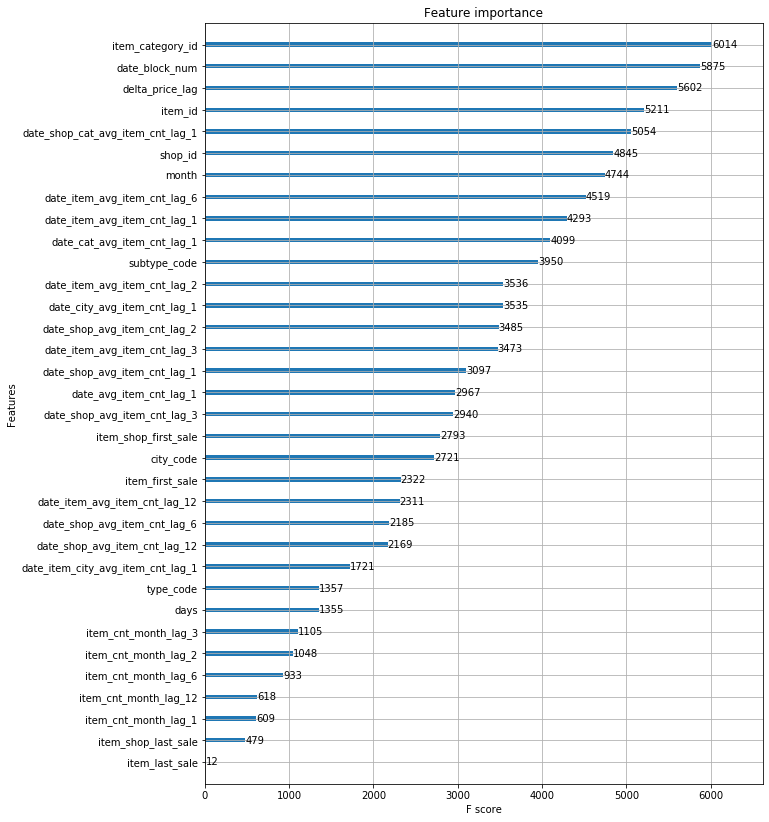

In [11]:
# Plot feature importance
plot_features(model, (10, 14))

In [12]:
# Prediction
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('../submission/xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('../submission/xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('../submission/xgb_test.pickle', 'wb'))